<a href="https://colab.research.google.com/github/killerbeelsl/weather_temperature_prediction_with_transformer/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [156]:
df = pd.read_csv('output_merged_no_filter_5000.csv')
df = df.sort_values(by=['ID', 'YEAR', 'MONTH'])

In [199]:
df = df[:5000]

In [200]:
# Remove rows where 'VALUE' is -9999
df = df[df['VALUE'] != -9999]

In [212]:
data = df.copy()

In [213]:
data["VALUE"] = data["VALUE"].apply(lambda x: x/100)

In [214]:
data

,ID,YEAR,MONTH,VALUE,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,NAME
0,ACW00011604,1961,1,-0.78,NaN,NaN,1.000000,0.553626,0.003992,SAVE
1,ACW00011604,1961,2,2.47,NaN,NaN,1.000000,0.553626,0.003992,SAVE
2,ACW00011604,1961,3,4.83,NaN,NaN,1.000000,0.553626,0.003992,SAVE
3,ACW00011604,1961,4,7.84,NaN,NaN,1.000000,0.553626,0.003992,SAVE
4,ACW00011604,1961,5,11.39,NaN,NaN,1.000000,0.553626,0.003992,SAVE
...,...,...,...,...,...,...,...,...,...,...
4995,ASN00014507,1961,1,28.93,E,NaN,0.364042,0.931293,0.004191,ALYANGULA_POLICE
4996,ASN00014507,1961,2,29.25,E,NaN,0.364042,0.931293,0.004191,ALYANGULA_POLICE
4997,ASN00014507,1961,3,28.71,E,NaN,0.364042,0.931293,0.004191,ALYANGULA_POLICE
4998,ASN00014507,1961,4,27.48,E,NaN,0.364042,0.931293,0.004191,ALYANGULA_POLICE


In [215]:
# 1. Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['LATITUDE', 'LONGITUDE', 'STNELEV']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

unchanged_features = ['YEAR', 'MONTH']


In [223]:
value_scaler = MinMaxScaler()
value_transformed = value_scaler.fit_transform(data['VALUE'].values.reshape(-1, 1)).reshape(-1)

In [224]:
# 2. One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse=False for array output
categorical_features = ['DMFLAG', 'QCFLAG']  # Include 'ID' for station embeddings
encoded_features = encoder.fit_transform(data[categorical_features])

In [225]:
data = data.drop(columns=['VALUE'])

In [226]:
X = np.concatenate([data[unchanged_features].values,encoded_features,
                   data[numerical_features].values], axis=1)
y = value_transformed  # Target variable

In [227]:
y

array([0.2284, 0.2934, 0.3406, ..., 0.8182, 0.7936, 0.7402])

In [228]:
num_features = X[1].shape[0]

In [229]:
num_features

10

In [230]:
# --- Sequence creation ---
sequence_length = 12  # Example sequence length (12 months)

X_sequences = []
y_sequences = []
for i in range(sequence_length, len(X)):
    X_sequences.append(X[i - sequence_length:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [231]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=42
)

In [232]:
batch_size = 64
num_epochs = 10

In [233]:
# --- Create PyTorch Datasets and DataLoaders ---
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))


train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [234]:
# --- Define the Transformer model ---
class TransformerModel(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(num_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer,
 num_layers)
        self.decoder = nn.Linear(d_model, 1)  # Output layer for temperature prediction

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Take the output from the last time step
        return output


In [235]:
# --- Model instantiation and training ---
model = TransformerModel(num_features=X_train.shape[2], d_model=512, nhead=8, num_layers=6, dim_feedforward=2048)

In [236]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [237]:
# --- Validation loop ---
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for src, target in val_loader:
            output = model(src)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [238]:
# --- Evaluation ---
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for src, target in test_loader:
            output = model(src)
            loss = criterion(output, target)
            total_loss += loss.item()
            all_predictions.extend(output.tolist())  # Store predictions
            all_targets.extend(target.tolist())  # Store true values

    # Calculate evaluation metrics (e.g., RMSE)
    rmse = np.sqrt(np.mean((np.array(all_predictions) - np.array(all_targets))**2))
    return total_loss / len(test_loader), rmse

In [239]:
# --- Training loop with validation ---
for epoch in range(num_epochs):
    # Training loop
  for src, target in train_loader:
      optimizer.zero_grad()
      output = model(src)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
  val_loss = validate(model, val_loader, criterion)
  print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/10], Validation Loss: 10.6859
Epoch [2/10], Validation Loss: 0.0247
Epoch [3/10], Validation Loss: 0.0249
Epoch [4/10], Validation Loss: 0.0258
Epoch [5/10], Validation Loss: 0.0275
Epoch [6/10], Validation Loss: 0.0238
Epoch [7/10], Validation Loss: 0.0273
Epoch [8/10], Validation Loss: 0.0275
Epoch [9/10], Validation Loss: 0.0246
Epoch [10/10], Validation Loss: 0.0282


In [240]:
# --- Final evaluation ---
test_loss, rmse = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, RMSE: {rmse:.4f}')

Test Loss: 0.0262, RMSE: 0.1614


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [243]:
original_min = value_scaler.data_min_[0]
original_max = value_scaler.data_max_[0]

In [244]:
original_min, original_max

(-12.2, 37.8)

In [245]:
original_rmse = rmse * (original_max - original_min) + original_min

In [246]:
original_rmse

-4.130144317361564

In [247]:
new_data = pd.read_csv('2010_data.csv')

In [255]:
new_data = new_data.sort_values(by=['ID', 'YEAR', 'MONTH'])

In [259]:
new_data = new_data[:1000]

In [284]:
# prompt: write a code to predict the temperature of new_data frame, do all the pre-processing needed, remove the temperature feature before passing to the model

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# ... (rest of your existing code)

def predict_temperature(new_data_df, model, scaler, encoder, value_scaler, original_min, original_max):
    """
    Predicts temperature for a new DataFrame.
    """

    # Preprocess the new data
    new_data_df[numerical_features] = scaler.transform(new_data_df[numerical_features])
    encoded_new_features = encoder.transform(new_data_df[categorical_features])
    new_data_df = new_data_df.drop(columns=['Temperature']) # assuming 'VALUE' exists in the new data as well
    new_X = np.concatenate([new_data_df[unchanged_features].values,encoded_new_features,
                   new_data_df[numerical_features].values], axis=1)

    # Create sequences from the new data
    X_new_sequences = []
    for i in range(sequence_length, len(new_X)):
      X_new_sequences.append(new_X[i - sequence_length:i])

    X_new_sequences = np.array(X_new_sequences)


    # Convert to PyTorch tensor
    X_new_tensor = torch.Tensor(X_new_sequences)

    # Make predictions
    model.eval()
    with torch.no_grad():
        new_predictions = model(X_new_tensor).tolist()

    # Inverse transform the predictions
    new_predictions_original_scale = np.array(new_predictions) * (original_max - original_min) + original_min

    return new_predictions_original_scale

# Example usage:
new_predictions = predict_temperature(new_data.copy(), model, scaler, encoder, value_scaler, original_min, original_max)
new_predictions = new_predictions.tolist()


In [287]:
new_pred  = [0.0]*12 + [x[0] for x in new_predictions]

In [289]:
len(new_pred)

1000

In [301]:
df = new_data.reset_index(drop=True)

In [303]:
df["Predicted Temperature"] = pd.Series(new_pred)

In [305]:
df

,ID,YEAR,MONTH,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,NAME,Temperature,Predicted Temperature
0,ACW00011604,2010,1,NaN,NaN,57.7667,11.8667,18.0,SAVE,-5.48,0.000000
1,ACW00011604,2010,2,NaN,NaN,57.7667,11.8667,18.0,SAVE,-3.49,0.000000
2,ACW00011604,2010,3,NaN,NaN,57.7667,11.8667,18.0,SAVE,1.90,0.000000
3,ACW00011604,2010,4,NaN,NaN,57.7667,11.8667,18.0,SAVE,7.19,0.000000
4,ACW00011604,2010,5,NaN,NaN,57.7667,11.8667,18.0,SAVE,11.27,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
995,AGM00060566,2010,12,NaN,NaN,32.3840,3.7940,460.9,NOUMERAT,13.80,21.862326
996,AGM00060571,2010,1,NaN,NaN,31.6460,-2.2700,811.1,BECHAR,12.11,21.862278
997,AGM00060571,2010,2,NaN,NaN,31.6460,-2.2700,811.1,BECHAR,16.08,21.862302
998,AGM00060571,2010,3,NaN,NaN,31.6460,-2.2700,811.1,BECHAR,19.07,21.862275


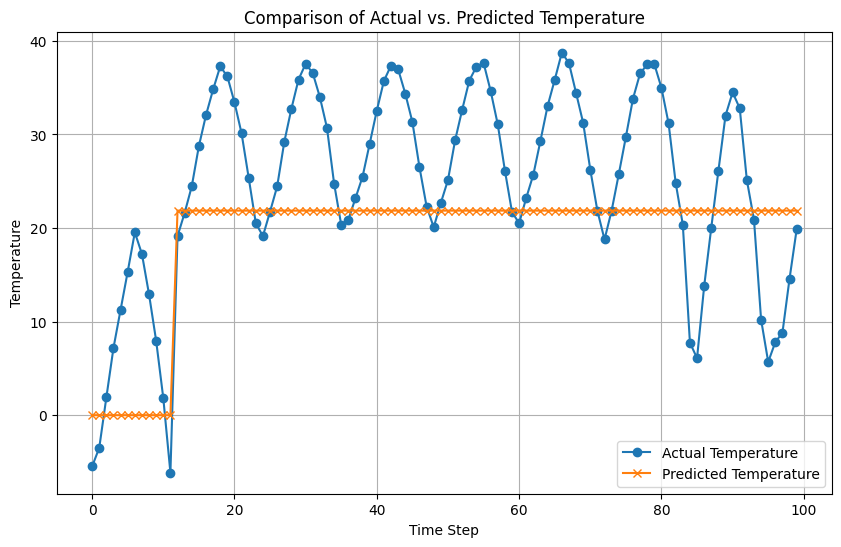

In [306]:
# prompt: create a plot to show the comparison between Temperature and predicted temperature

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Temperature' and 'Predicted Temperature' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Temperature'][:100], label='Actual Temperature', marker='o')
plt.plot(df['Predicted Temperature'][:100], label='Predicted Temperature', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs. Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()